## Отслеживание соседей

[1 1]


C:\Users\tigra\AppData\Local\Temp\ipykernel_2460\240953895.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  popal.append([1,2][an<0])


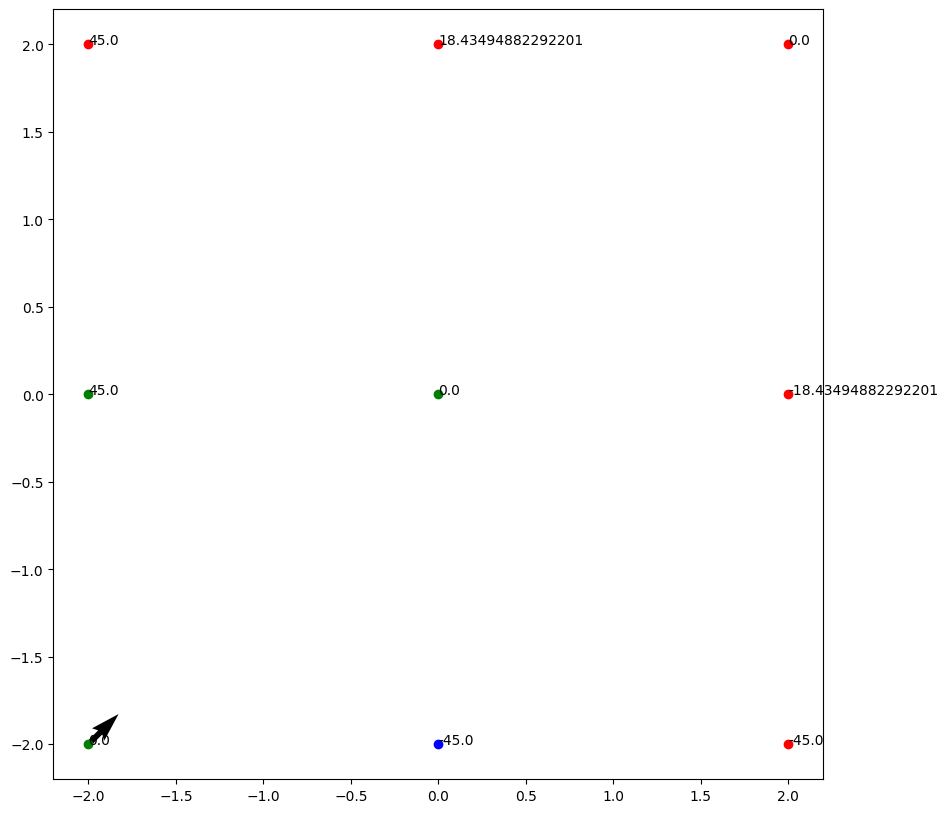

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# v1 = np.array(list(map(int, input().split())))

def awd(a, b):
    dot_product = np.dot(a, b)
    det = a[0] * b[1] - a[1] * b[0]
    angle = np.arctan2(det, dot_product)
    return np.degrees(angle)

r = 3
ang = 150
p1 = np.array([-2, -2])
points = np.array([
    [1,0],
    [0,0],
    [1,1],
    [0,1],
    [-1,1],
    [-1,0],
    [-1,-1],
    [0,-1],
    [1,-1]
])
points *= 2
angles = []
popal = []
v1 = np.array([1,1])
for i in points:
    # v2 = np.random.randint(0, 11, 2)
    # pts.append(v2.copy())
    v2 = i.copy()
    v2-=p1
    
    # print(np.linalg.norm(v1), np.linalg.norm(v2))
    # t = v1@v2 / (np.linalg.norm(v1) * np.linalg.norm(v2))
    # an = round(np.arccos(t)*180/np.pi)
    an = awd(v1,v2)
    angles.append(an)
    if np.linalg.norm(v2) <= r and abs(an) <= ang/2:
        # det = v1[0]*v2[1] - v1[1]*v2[0]
        popal.append([1,2][an<0])
    else:
        popal.append(0)

fig, ax = plt.subplots(figsize=(12,10))
ax.quiver(p1[0], p1[1], v1[0], v1[1])
for i in range(len(points)):
    p = points[i]
    # ax.plot([p1[0], p[0]], [p1[1], p[1]], 'rgb'[popal[i]])
    ax.scatter(p[0],p[1], c='rgb'[popal[i]])
    ax.text(p[0], p[1], angles[i])
print(v1)
ax.set_aspect('equal', adjustable='box')
plt.show()

### Реализация

In [1]:
import matplotlib.pyplot as plt
def draw(agents, t):
    plt.clf()  # Очистка текущего графика
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    for i in agents:
        plt.scatter(*i.coords, c='gyrb'[i.state])
        plt.quiver(*i.coords, *(i.dir), width=0.005)
        # print(*i.coords, *(i.dir*i.v), i.dir*i.v)
        # plt.text(*i.coords, i.dir)
    # plt.axis([0,100,0,100])
    plt.title(f'Состояние среды t={t}')

In [2]:
import numpy as np

class State:
    healthy = 0
    infected = 1
    zombie = 2
    recovered = 3
    v_scaler = [1, 0.9, 0.85, 1]
    r_scaler = [1, 1, 1.1, 1]
    a_scaler = [1, 1, 0.75, 1]

t_inc_min = 1
t_inc_max = 10

class Agent:
    def __init__(self, id, v, r):
        self.id = id
        self.coords = np.random.randint(0, 101, 2)
        self.t_inc = -1
        self.state = State.healthy
        
        self.ang = np.random.randint(90, 151)
        self.v = v
        self.r = r

        self.dir = np.random.rand(2)*2-1 # направление движения
        self.dir /= np.linalg.norm(self.dir) # нормализация
        # self.a_h = self.a # а здорового агента
    
    def get_rad(self):
        return self.r*State.r_scaler[self.state]
    
    def get_ang(self):
        return self.ang*State.a_scaler[self.state]

    # Возвращаем угол и расстояние до другого агента
    def look(self, other):
        a, b = self.dir.copy(), other.coords-self.coords
        dot_product = np.dot(a, b)
        det = a[0] * b[1] - a[1] * b[0]
        angle = np.arctan2(det, dot_product)
        return np.degrees(angle), np.linalg.norm(b)

    def move(self, run=False):
        v = self.v*State.v_scaler[self.state] # факт. скорость
        self.coords = self.coords + self.dir*v*[1,1.25][run]
        if not 0<=self.coords[0]<101:
            self.dir[0] *= -1
            self.coords[0] = 100-(self.coords[0]%100)
        if not 0<=self.coords[1]<101:
            self.dir[1] *= -1
            self.coords[1] = 100-(self.coords[1]%100)

    def __repr__(self):
        return f"Agent{self.id} ({self.x}, {self.y})"
    
    def __str__(self):
        return self.__repr__()

### Симуляция

In [184]:
def rotate_vector(vector, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])
    rotated_vector = rotation_matrix.dot(vector)
    return rotated_vector / np.linalg.norm(rotated_vector)

def sim(n, m, T, visualize=False, log=False):
    r = 50
    v = 10
    agents = []
    for i in range(n):
        agents.append(Agent(i, v, r))

    t_init = np.random.randint(1, 20)
    m_agents = np.random.choice(n, m, replace=False)
    if log:
        print(m_agents)
    for t in range(t_init):
        for a in agents:
            a.move()

    for i in m_agents:
        agents[i].t_inc = t + np.random.randint(t_inc_min, t_inc_max)
        agents[i].state = State.infected
    
    def is_all_zombies():
        temp = sum([i.state==State.zombie for i in agents])
        # print(temp)
        return temp  == len(agents)
    def no_zombies():
        temp = sum([(i.state in [State.infected, State.zombie]) for i in agents])
        # print(temp)
        return temp == 0
    
    t = t_init
    early_break = 0
    while (t < T) and (not is_all_zombies()):
        t += 1
        temp = no_zombies()
        # print(temp)
        if temp:
            early_break = 1
            break
        for a in agents:
            # Прошел инкубационный период
            if a.t_inc != -1 and a.t_inc == t:
                a.state = State.zombie
                a.t_inc = -1
                if log:
                    print(f'{t}: Agent{a.id} стал зомби')
            
            # Вероятность выздороветь 1%
            if a.state == State.zombie:
                if np.random.choice(2, p=[0.99, 0.01]):
                    a.state = State.recovered
                    if log:
                        print(f'{t}: Agent{a.id} выздоровел')
            
            # Бежит ли агент
            run = False
            temp = []
            
            # Собираем агентов из области видимости
            for b in agents:
                if b.id != a.id:
                    ang, dist = a.look(b)
                    if abs(ang) <= a.get_ang()/2 and dist <= a.get_rad():
                        temp.append((b, ang, dist))
            
            match a.state:
                # Здоровый агент убегает если рядом зомби
                case State.healthy:
                    right, left = False, False
                    for b,ang,dist in temp:
                        if b.state == State.zombie:
                            if ang <= 0:
                                right = True
                            else:
                                left = True
                    if right or left:
                        run = True
                        if right and left:
                            a.dir *= -1
                        elif right:
                            a.dir = rotate_vector(a.dir, a.ang/2)
                        else:
                            a.dir = rotate_vector(a.dir, -a.ang/2)
                # Зомби заражает агента из области действия
                # или бежит за ближайшим агентом из области видимости
                case State.zombie:
                    r_min = -1
                    an_min = -1
                    
                    for b,ang,dist in temp:
                        if b.state in [State.recovered, State.healthy]:
                            if dist <= a.get_rad()*0.93 and abs(ang) <= a.get_ang()*0.93:
                                # Заражает агентов из области действия
                                if b.state == State.healthy:
                                    b.state = State.infected
                                    if log:
                                        print(f'{t}: Agent{a.id} заболел')
                                    b.t_inc = t + np.random.randint(t_inc_min, t_inc_max)
                                # С вероятностью 25% обращает в зомби выздоровевшего агента
                                elif np.random.choice(2, p=[0.75, 0.25]):
                                    b.state = State.zombie
                                    if log:
                                        print(f'{t}: Agent{a.id} стал зомби')
                            # Гонится за ближайшим здоровым агентом
                            elif b.state == State.healthy:
                                if r_min == -1:
                                    r_min = dist
                                    an_min = ang
                                elif r_min > dist:
                                    r_min = dist
                                    an_min = ang
                    if r_min != -1:
                        a.dir = rotate_vector(a.dir, an_min)
                

            a.move(run)
    if visualize:
        draw(agents, t)
    
    return t, early_break

In [199]:
ns = [20, 50, 100, 120]
ms = [0.1, 0.3, 0.5, 0.8]
T = 100
d = {'n':[], 'm':[], 't':[], 'early_break':[]}
for n in ns:
    print(n)
    for m in ms:
        s = 0
        brk = 0
        m_t = int(m*n)
        k = 10
        for _ in range(k):
            a,b = sim(n, m_t, T)
            s+=a
            brk+=b
        d['n'].append(n)
        d['m'].append(m_t)
        d['t'].append(s/k)
        d['early_break'].append(brk/k)


20
50
100
120


In [200]:
import pandas as pd

pd.DataFrame(d)

,n,m,t,early_break
0,20,2,48.2,0.0
1,20,6,57.1,0.0
2,20,10,63.7,0.0
3,20,16,84.2,0.0
4,50,5,56.4,0.0
5,50,15,83.6,0.0
6,50,25,100.0,0.0
7,50,40,100.0,0.0
8,100,10,77.3,0.0
9,100,30,100.0,0.0


In [197]:
df

,n,m,t,early_break
0,20,2,45.449,0.0
1,20,6,62.893,0.0
2,20,10,77.972,0.0
3,20,16,88.939,0.0
4,50,5,58.063,0.0
5,50,15,87.277,0.0
6,50,25,96.238,0.0
